In [3]:
%matplotlib inline 
import numpy as np
import pandas as pd 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

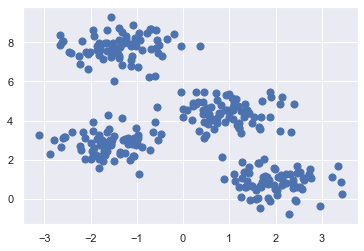

In [5]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 300, centers = 4,
                      cluster_std = 0.6, random_state = 0)
plt.scatter(X[:, 0], X[:,1], s = 50)

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

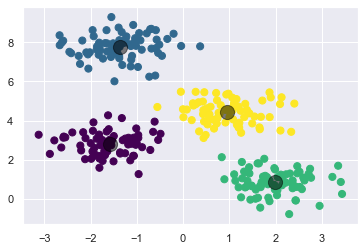

In [10]:
plt.scatter(X[:,0], X[:,1], c = y_kmeans, cmap = 'viridis', s = 50)
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c = 'black', s = 200, alpha = 0.5)

# K-means implementation


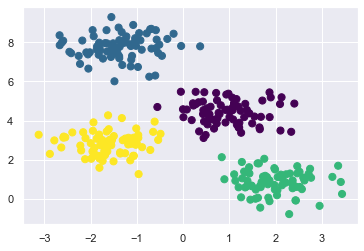

In [14]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed = 2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters] # random perfutate a sequence
    # if it is a multi-dimensional array, only shuffled along the first index
    centers = X[i] # intialize the centers
    
    while True:
        
        labels = pairwise_distances_argmin(X, centers) # assign lables for the data beased on closest center
        # get the new center 
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        
        if np.all(centers == new_centers): # to check whether the new_centers are different with the old ones
            break  # if the same, break the iteration
        
        centers = new_centers
        
    return centers, labels
    

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c = labels, s= 50,
           cmap = 'viridis')

# Caveats of expectation–maximization

###  The globally optimized result may not be achieved

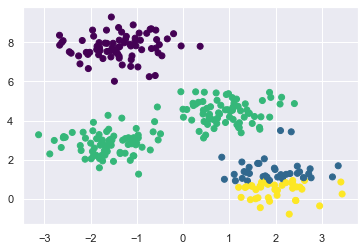

In [16]:
centers, labels = find_clusters(X,4, 0)
plt.scatter(X[:,0], X[:,1], c = labels, cmap = 'viridis')

### The number of clusters must be selected beforehand

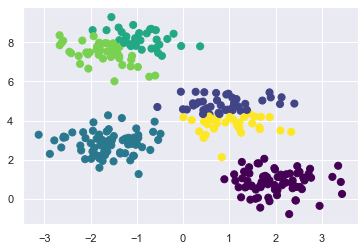

In [18]:
labels = KMeans(n_clusters = 6, random_state = 0).fit_predict(X)
plt.scatter(X[:,0], X[:,1], s = 50, c = labels,
           cmap = 'viridis')

### k-means is limited to linear cluster boundaries

In [20]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise = 0.05, random_state = 0)

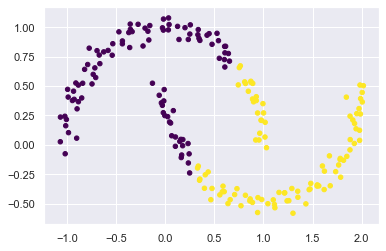

In [21]:
labels = KMeans(2, random_state = 0).fit_predict(X)
plt.scatter(X[:,0], X[:,1], s = 20, c = labels,
           cmap = 'viridis')

/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


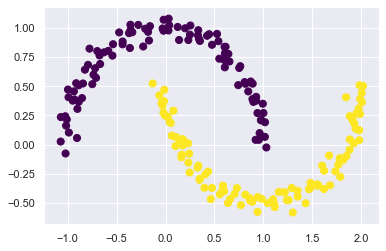

In [22]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors',
                          assign_labels = 'kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### k-means can be slow for large numbers of samples

# Examples

### Kmeans in Digits 

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [25]:
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

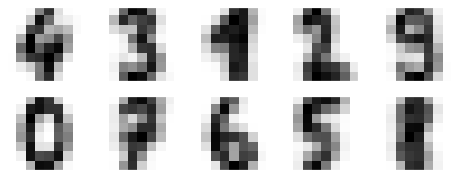

In [28]:
fig, axes = plt.subplots(2, 5, figsize = (8,3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(axes.flat, centers):
    ax.set(xticks = [], yticks = [])
    ax.imshow(center, interpolation = 'nearest', cmap = plt.cm.binary)

In [31]:
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = [clusters == i]
    labels[mask] = mode(digits.target[mask])[0]
labels[0:10]

/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


array([0, 8, 8, 3, 4, 9, 6, 7, 8, 9], dtype=int32)

In [33]:
print(labels)
print(clusters)

[0 8 8 ... 8 9 9]
[5 9 9 ... 9 4 4]


In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

Text(30.5, 0.5, 'predicted label')

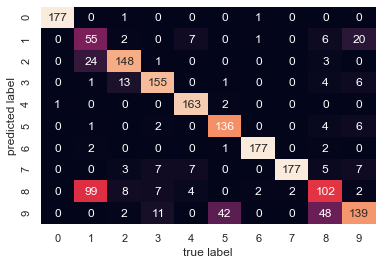

In [43]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, 
            annot = True, # to shown the text in each small box
            fmt = 'd', # to show only int
            cbar = False, # remove the color bar
           yticklabels = digits.target_names,
           xticklabels = digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [48]:
from sklearn.manifold import TSNE #t-distributed stochastic neighbor embedding (t-SNE)
# Project the data
tsne = TSNE(n_components = 2, init = 'random', random_state = 0)
digits_proj = tsne.fit_transform(digits.data)
# Compute the clusters
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)


0.9371174179187535

## k-means for color compression

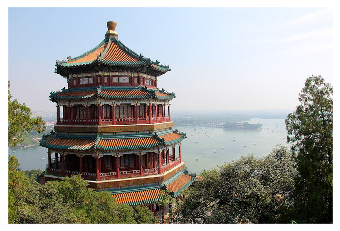

In [49]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
ax = plt.axes(xticks = [], yticks =[])
ax.imshow(china)

In [50]:
china.shape


(427, 640, 3)

In [123]:
type(china)

numpy.ndarray

In [124]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [127]:
def plot_pixels(data, title, colors = None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset of 10000
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R,G,B = data[i].T # R,G,B are the rows for the matrix
    
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].scatter(R, G, color = colors, marker = '.')
    ax[0].set(xlabel = 'Red', ylabel = 'Green', xlim = (0,1), ylim =(0,1))
    
    ax[1].scatter(R,B,color = colors, marker = '.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    fig.suptitle(title, size=20);
    

In [125]:
r,g,b = data[0:3].T

In [126]:
print(china[0,0,0:3])
print(';')
print(r)
print(g)
print(b)

[174 201 231]
;
[0.68235294 0.68235294 0.68235294]
[0.78823529 0.78823529 0.78823529]
[0.90588235 0.90588235 0.90588235]


In [104]:
data[0:3]

array([[174, 201, 231],
       [174, 201, 231],
       [174, 201, 231]], dtype=uint8)

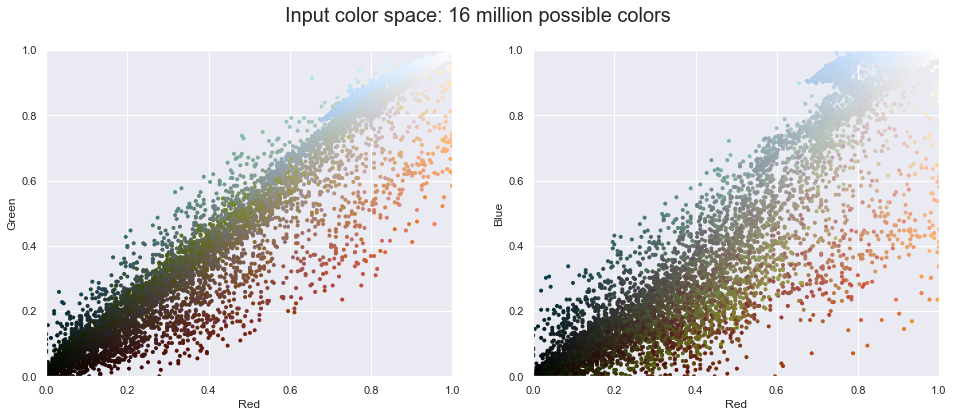

In [128]:
plot_pixels(data, title='Input color space: 16 million possible colors') # 255**3

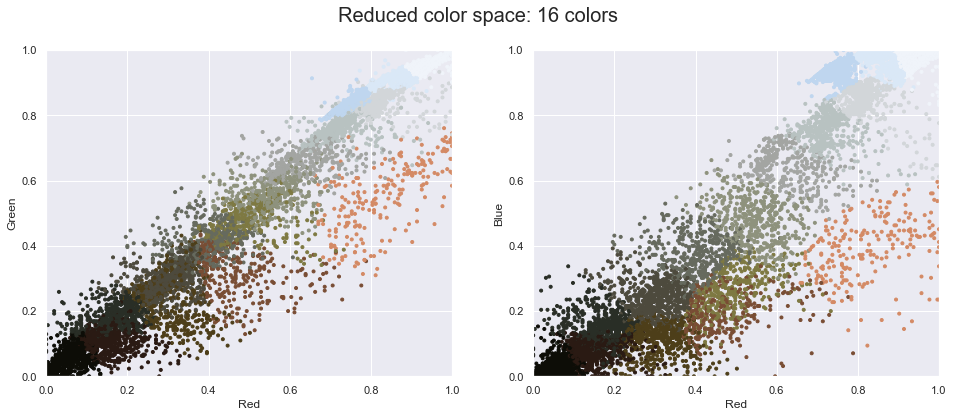

In [129]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

In [138]:
kmeans.predict(data).shape

(273280,)

In [135]:
new_colors.shape

(273280, 3)

In [137]:
kmeans.cluster_centers_.shape

(16, 3)

In [139]:
kmeans.predict(data)

array([ 5,  5,  5, ..., 11, 12, 12], dtype=int32)

In [140]:
new_colors

array([[0.7483425 , 0.83817182, 0.93855269],
       [0.7483425 , 0.83817182, 0.93855269],
       [0.7483425 , 0.83817182, 0.93855269],
       ...,
       [0.15981546, 0.1822376 , 0.14934256],
       [0.05115214, 0.05178188, 0.02911121],
       [0.05115214, 0.05178188, 0.02911121]])

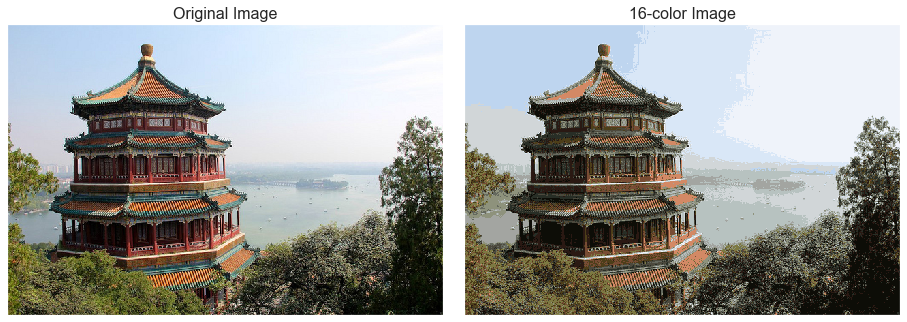

In [144]:
china_recolored = new_colors.reshape(china.shape)
fig, ax = plt.subplots(1,2,figsize = (16,6),
                      subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);